2.1.4
Our accuracy :  77.66990291262135 %
sklearn accuracy :  67.31391585760518 %


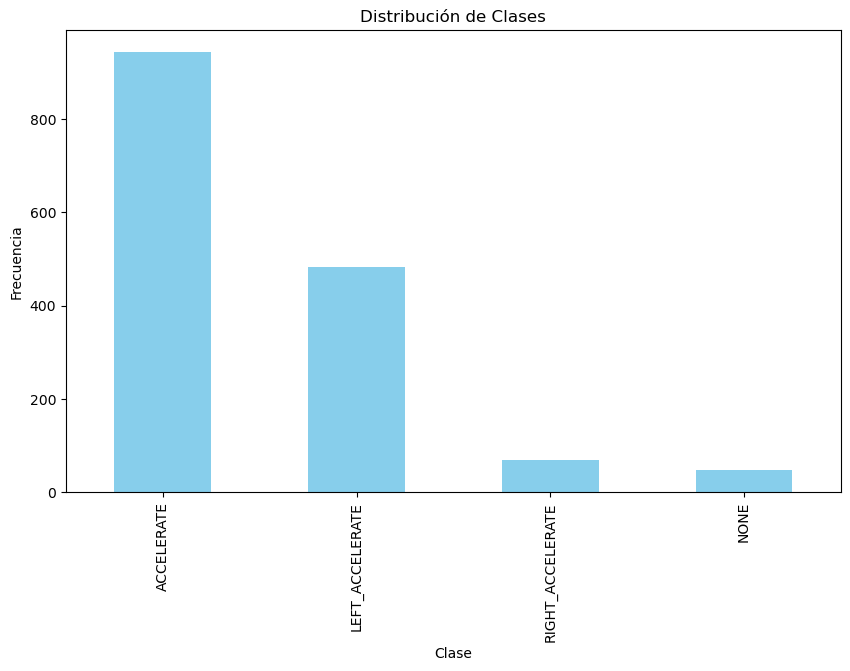

In [12]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from ann import costL2, backprop, forwardprop, iterateThetas

from Utils import ExportThetasToFile
from Utils import CreateTxt

import pandas as pd

print(pd.__version__)

# EJERCICIO 2 - visualiza los datos

# Cargar los datos desde el archivo CSV
data = pd.read_csv("data/kartAllData.csv", header=None, names=["dist1", "dist2", "dist3", "dist4", "dist5", 
                                                           "x", "y", "z", "tiempo", "accion"])

# Eliminar las columnas de posición y tiempo ya que consideramos que no son tan relevantes como la distancia de los raycast
cleanDataset = data.drop(["y", "tiempo"], axis=1)
numInputs = 7

# Realizar one-hot encoding para la columna "accion"
one_hot_encoded = pd.get_dummies(data["accion"], prefix="accion")

# Añadir los valores generados del one_hot_encoded al dataset
cleanDataset = pd.concat([cleanDataset, one_hot_encoded], axis=1)
cleanDataset = cleanDataset.drop(["accion"], axis=1)

# Utilizaremos los valores de las distancias de los 5 raycast como input
X = cleanDataset.iloc[:, :numInputs]
# Mientras que utilizaremos los 7 estados de accion, pasados por one_hot_encoded
Y = cleanDataset.iloc[:, numInputs:]

#==Normalizacion
from sklearn.preprocessing import StandardScaler

scaling=StandardScaler()
scaling.fit(X)
X=scaling.transform(X)


#========DIVIDIR DATOS ENTRE ENTRENAMIENTO Y DE TEST==========================
from sklearn.model_selection import train_test_split
X, X_test, Y, Y_test = train_test_split(X, Y, train_size = 0.8, random_state = 1234)


# Visualizar la distribución de clases
class_distribution = data["accion"].value_counts()

# Graficar la distribución de clases
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
#plt.show()

# EJERCICIO 4 - Prueba diferentes modelos de Machine Learning


# Entrenar modelo con backpropagation

neuronsInputLayer = X.shape[1]
neuronsFirstHiddenLayer = 7
neuronsOutputLayer = Y.shape[1]

e = 0.12
iterations = 5000
myAlpha = 0.9
myLambda = 0.9

# Valores aleatorios en theta1 y theta2
theta1 = np.random.uniform(low=-e, high=e, size=( neuronsFirstHiddenLayer, neuronsInputLayer+1))
theta2 = np.random.uniform(low=-e, high=e, size=(neuronsOutputLayer, neuronsFirstHiddenLayer+1))
#theta3 = np.random.uniform(low=-e, high=e, size=(99, +1))
#theta4 = np.random.uniform(low=-e, high=e, size=(99, +1))

## Ajustar thetha1 y theta2 teniendo en cuenta los parametros dados
#thetas = iterateThetas([theta1, theta2], X, Y, iterations, myLambda, myAlpha)


#########################################################
####### Compara los resultados con SKLearn ##############
#########################################################

# Entrenar a SKLearn con los mismos valores
from sklearn.neural_network import MLPClassifier
hidden_layer_sizes = (neuronsFirstHiddenLayer)
sklearn_neural_network = MLPClassifier(
    alpha=myLambda, 
    learning_rate_init=myAlpha, 
    activation='logistic',
    hidden_layer_sizes=hidden_layer_sizes,
    max_iter = iterations
)
sklearn_neural_network.fit(X, Y)


# Ajustar thetha1 y theta2 teniendo en cuenta los parametros dados
thetas = iterateThetas([theta1, theta2], X, Y, iterations, myLambda, myAlpha)

#====================================================================================

## Realizar la propagación hacia adelante

# Predicciones con MLPClassifier
layerValues_sklearn = sklearn_neural_network.predict(X_test)
sklearnPredictions = np.argmax(layerValues_sklearn, axis=1)
#print("SklearnPredictions:", sklearnPredictions[:1000])

picklefileName = "modelo.pickle"
onixFileName = "modelo.onnx"
jsonFileName = 'modelo.json'
customFileName = 'modelo_custom.txt'

ExportThetasToFile(thetas, "../Assets/modelo1.txt")
CreateTxt(thetas, "../Assets/modelo2.txt")

layerValues, weighted_inputs = forwardprop(thetas, X_test)
#print("layerValues[-1].shape: ", layerValues[-1].shape)
#print("Y_test.shape: ", Y_test.shape)
#print("Y_test: ", Y_test[:100])

myPredictions = np.argmax(layerValues[-1], axis=1)

YTest_Values = np.argmax(Y_test, axis=1)

#print("MyPredictions.shape: ", myPredictions.shape)
#print("YTest_Values.shape: ", YTest_Values.shape)
#print("MyPredictions:", myPredictions[:549])
#print("YTest_Values:", YTest_Values[:549])

myAccuracy_booleans = myPredictions == YTest_Values
myAccuracy = np.mean(myAccuracy_booleans) * 100
print("Our accuracy : ", myAccuracy, "%")


sklearnAccuracy_booleans = sklearnPredictions == YTest_Values
sklearnAccuracy = np.mean(sklearnAccuracy_booleans) * 100
print("sklearn accuracy : ", sklearnAccuracy, "%")

